In [1]:
# Establece las librerias del sistema
# Manejo de datos
import pandas as pd
import numpy as np
# Maejo de directorios y archivos
import os
import glob
# Librerias de pronotiscos
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.stats.outliers_influence import summary_table
from statsmodels.tsa.seasonal import seasonal_decompose
# Advertencias del sistema
import warnings
warnings.filterwarnings('ignore')



# Funciones internas
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def wmape(actual, forecast):
    actual,forecast = np.array(actual), np.array(forecast)
    se_mape = np.abs(actual-forecast)/actual
    ft_actual_sum = np.sum(actual)
    se_actual_prod_mape = actual * se_mape
    ft_actual_prod_mape_sum = np.sum(se_actual_prod_mape)
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum
    return ft_wmape_forecast * 100

In [2]:

categoria =  'CarnicosData'
vista = categoria + "-ini"
path = ( categoria +  '.xlsx')
xl = pd.ExcelFile(path)
fecha_inicio = '2020-03-02'
pproyeccion = 72
print(xl.sheet_names)


df0 = xl.parse('dt')
df1= pd.DataFrame(df0)


dir_actual = os.getcwd()

Pais = "Carnico-Periodo-3Meses"

path = os.path.join(dir_actual, Pais)

try:
  os.mkdir(path)
except:
  print("An exception occurred")


['Hoja2', 'Hoja3', 'E3', 'e2', 'e1', 'dt2', 'dt', 'dt1']
An exception occurred


In [3]:
e1 = pd.pivot_table(df1, values='Cantidad', index=['Fecha'],columns=['Linea'], aggfunc=np.sum)
tpath = os.path.join(path,"Lineas.xlsx")
e1['Periodo'] = pd.date_range(start="2/02/2020", periods=e1.shape[0], freq="W")
e1.to_excel(tpath)
print(e1)


Linea       Chorizo y Variedades    Salchicha    Periodo
Fecha                                                   
2020-03-02            282166.047  1079965.096 2020-02-02
2020-03-09            299151.658  1142863.117 2020-02-09
2020-03-16            367175.023  1381084.385 2020-02-16
2020-03-23            317525.847  1306365.189 2020-02-23
2020-03-30            315382.136  1366658.005 2020-03-01
...                          ...          ...        ...
2023-01-09            432397.768  1509996.229 2022-12-18
2023-01-16            324708.342  1323359.776 2022-12-25
2023-01-23            360031.838  1464297.433 2023-01-01
2023-01-30            354737.917  1459795.078 2023-01-08
2023-02-06            323462.047  1366814.121 2023-01-15

[155 rows x 3 columns]


In [4]:
dfc = df1[(df1.Linea == 'Chorizo y Variedades')]
dfs = df1[(df1.Linea == 'Salchicha')]
e2c = pd.pivot_table(dfc, values='Cantidad', index=['Fecha'],columns=['Centro Distribución'], aggfunc=np.sum, margins=True,margins_name="Total")
e2s = pd.pivot_table(dfs, values='Cantidad', index=['Fecha'],columns=['Centro Distribución'], aggfunc=np.sum,margins=True,margins_name="Total")
#Copia el dataframe para rellenar con menor sesgo posteriormente
#Chorizos
e2cn = e2c.copy(deep=True)
Ntotalc =e2c["Total"]/e2c["Total"].loc["Total"]
e2cn.iloc[0:155] = e2c.loc["Total"]
e2c["NTotal"] = Ntotalc
e2cn = e2cn.multiply(e2c["NTotal"], axis = "index")
#Salchichas
e2sn = e2s.copy(deep=True)
Ntotals =e2s["Total"]/e2s["Total"].loc["Total"]
e2sn.iloc[0:155] = e2s.loc["Total"]
e2s["NTotal"] = Ntotals
e2sn = e2sn.multiply(e2s["NTotal"], axis = "index")

spath = os.path.join(path,"CenDis_Salchicha_Procesado.xlsx")
cpath = os.path.join(path,"CenDis_Chorizo_Procesado.xlsx")
#Rellena dt con los datos de menor sesgo
e2c = e2c.fillna(e2cn)
e2s= e2s.fillna(e2sn)


e2c.to_excel(cpath)
e2s.to_excel(spath)

In [5]:
cdlist = df1["Centro Distribución"].unique()
pivotlistc = {}
pivotlists = {}
pivotlistc2 = {}
pivotlists2 = {}
#Crea las tablas pivote de material por centro de distribucion
for Cd in cdlist:
    dfccd = dfc[(dfc["Centro Distribución"] == Cd)]
    dfscd = dfs[(dfs["Centro Distribución"] == Cd)]

    e3c = pd.pivot_table(dfccd, values='Cantidad', index=['Fecha'],columns=['Codmat'], aggfunc=np.sum)
    e3s = pd.pivot_table(dfscd, values='Cantidad', index=['Fecha'],columns=['Codmat'], aggfunc=np.sum)
    e3c2 = pd.pivot_table(dfccd, values='Cantidad', index=['Fecha'],columns=['Codmat'], aggfunc=np.sum, margins=True,margins_name="Total")
    e3s2 = pd.pivot_table(dfscd, values='Cantidad', index=['Fecha'],columns=['Codmat'], aggfunc=np.sum, margins=True,margins_name="Total")
    pivotlistc[Cd]=(e3c)
    pivotlists[Cd]=(e3s)
    pivotlistc2[Cd]=(e3c2)
    pivotlists2[Cd]=(e3s2)
print(pivotlists["NN18"])


Codmat      M1000031  M1000814  M1000820  M1000821  M1000833  M1000840  \
Fecha                                                                    
2020-03-02   701.195   486.851  1656.609  1134.815   881.475    83.545   
2020-03-09   834.006   311.220  2074.055  1525.621   980.146    95.945   
2020-03-16   743.755  1717.170  3135.832  1083.117   856.982    81.995   
2020-03-23   675.452   653.380  2788.510   286.701  1306.517    28.211   
2020-03-30   833.723   673.400  3075.938   425.585  1296.165    22.940   
...              ...       ...       ...       ...       ...       ...   
2023-01-09  2526.750   285.000  5153.000  2503.000  1617.500   287.500   
2023-01-16  2251.469   348.000  4564.000  2492.875  1360.563   343.000   
2023-01-23  2048.250   510.000  5125.500  2522.547  1317.500   250.000   
2023-01-30  1999.750   607.000  5780.000  2547.115  1377.500   372.500   
2023-02-06  1765.000   395.000  4878.500  2467.067  1034.500   297.500   

Codmat      M1000845  M1000849   M100

In [6]:
sframe = pd.DataFrame()
cframe = pd.DataFrame()
#Dataframe de las categorias
cframe.index = ['A','B','C']
sframe.index = ['A','B','C']
dfproyeccioness = {}
dfproyeccionesc = {}
matstoprojects = {}
matstoprojectc = {}

def categoria(x):
    if x == 100:
        return 'A'
    elif x >= 90:
        return 'B'
    elif x < 90 or x is None:
        return 'C'

def matrizsesgo(x2,rows):
    xn = x2.copy(deep=True)

    Ntotalc =x2["Total"]/x2["Total"].loc["Total"]
    xn.iloc[0:rows] = xn.loc["Total"]
    x2["NTotal"] = Ntotalc
    xcn = xn.multiply(x2["NTotal"], axis = "index")
    return xcn

for cd in cdlist:
    df2 = pivotlistc[cd]
    df2t = pivotlistc2[cd]
    rowsch = df2t.shape[0]
    mirrorc = matrizsesgo(df2t,rowsch)
    #Cuenta los datos no vacios, convierte a porcentaje y categoriza
    df3 = df2.count()
    df3 = df3.divide(155).multiply(100)
    df3a= df3.apply(categoria)
    aprovedc = df3a[df3a == "A"]
    aprovedc = list(aprovedc.index.values)
    matstoprojectc[cd] = aprovedc
    df3a=df3a.value_counts()
    cframe[cd] = df3a

    df4 = pivotlists[cd]
    df4t = pivotlists2[cd]
    rowssal = df4t.shape[0]
    mirrors = matrizsesgo(df4t,rowssal)
    df5 = df4.count()
    df5 = df5.divide(155).multiply(100)
    df5a= df5.apply(categoria)
    aproveds = df5a[df5a == "A"]
    aproveds = list(aproveds.index.values)
    matstoprojects[cd] = aproveds
    df5a=df5a.value_counts()
    sframe[cd] = df5a

    df2.fillna(mirrorc, inplace=True)
    df4.fillna(mirrors, inplace=True)
    dfproyeccionesc[cd] = df2
    dfproyeccioness[cd] = df4

spath = os.path.join(path,"Reporte_Salchichas.xlsx")
cpath = os.path.join(path,"Reporte_Chorizos.xlsx")
#Guarda el reporte en excel
print(sframe)
print(cframe)
sframe.to_excel(spath, index_label="Periodo")
cframe.to_excel(cpath, index_label="Periodo")
print("Termino")

   NN13  NN14  NN18  NN20  NN21  NN24  NN27  NN29  NN53  NN97  NNB1  NNB2  \
A    30    27    30    24    27    22    16    25    24    25   NaN    23   
B     5     8     5    10     8    12    15     7     8    10  21.0     6   
C     7     7     9     6     5     8     7     8     4     4  10.0     8   

   NNB8  
A    25  
B     8  
C     5  
   NN13  NN14  NN18  NN20  NN21  NN24  NN27  NN29  NN53  NN97  NNB1  NNB2  \
A     2     2     3   NaN     2    11   NaN     3     1     1     1   NaN   
B    18    18    12  13.0    11     2  13.0    10    12    19    11  13.0   
C     3     3     2   2.0     2     2   2.0     3     2     3     1   2.0   

   NNB8  
A   NaN  
B  14.0  
C   2.0  
Termino


MAPE NN13-M1000497 = 15.705861317639048
WMAPE NN13-M1000497 = 15.927507803834947
MAPE NN13-M1000794 = 17.604699541381173
WMAPE NN13-M1000794 = 17.222238719138154
MAPE NN13-M1000820 = 14.96508740556365
WMAPE NN13-M1000820 = 14.204387498527154
MAPE NN13-M1000821 = 59.98387253511645
WMAPE NN13-M1000821 = 27.208557787729287
MAPE NN13-M1000833 = 15.658343970357935
WMAPE NN13-M1000833 = 15.09583443115532
MAPE NN13-M1000845 = 15.967335430468294
WMAPE NN13-M1000845 = 16.07832158522953
MAPE NN13-M1000849 = 13.658147712757401
WMAPE NN13-M1000849 = 13.652153321217494
MAPE NN13-M1000852 = 11.603837504495196
WMAPE NN13-M1000852 = 12.48277976082587
MAPE NN13-M1000853 = 17.361016998231094
WMAPE NN13-M1000853 = 17.45205931149708
MAPE NN13-M1001014 = 10.792135544939189
WMAPE NN13-M1001014 = 10.74686188812075
MAPE NN13-M1012343 = 12.982023937882042
WMAPE NN13-M1012343 = 12.90268978503328
MAPE NN13-M1012346 = 23.611138199566867
WMAPE NN13-M1012346 = 17.184402490853117
MAPE NN13-M1012347 = 12.837132179160

MAPE NN20-M1000849 = 21.11231411635827
WMAPE NN20-M1000849 = 19.978321051570454
MAPE NN20-M1000852 = 13.888511438830939
WMAPE NN20-M1000852 = 14.225681109108685
MAPE NN20-M1000853 = 15.665915028248806
WMAPE NN20-M1000853 = 16.191690372680288
MAPE NN20-M1001311 = 16.653228473071373
WMAPE NN20-M1001311 = 15.795301159948538
MAPE NN20-M1009337 = 6.565366497582695
WMAPE NN20-M1009337 = 6.463083093338915
MAPE NN20-M1012329 = 14.053154971284233
WMAPE NN20-M1012329 = 13.963090003828931
MAPE NN20-M1012331 = 13.05243447117809
WMAPE NN20-M1012331 = 13.167767391899012
MAPE NN20-M1012343 = 16.984476789429348
WMAPE NN20-M1012343 = 16.61788062273776
MAPE NN20-M1012347 = 19.021739884015165
WMAPE NN20-M1012347 = 17.080552381991556
MAPE NN20-M1015605 = 14.52260919799583
WMAPE NN20-M1015605 = 13.990839730864774
MAPE NN20-M1017925 = 28.71084187803399
WMAPE NN20-M1017925 = 26.02759546752103
MAPE NN20-M1019943 = 9.24433133841046
WMAPE NN20-M1019943 = 8.866618793349906
MAPE NN20-M1019944 = 11.779031864566027

MAPE NN27-Total = 6.938668522014685
WMAPE NN27-Total = 6.999054218195832
MAPE NN27-Total = 15.651541634494004
WMAPE NN27-Total = 11.133959625486087
MAPE NN29-M1000031 = 17.350031205799638
WMAPE NN29-M1000031 = 23.265403598643932
MAPE NN29-M1000814 = 16.267854813364988
WMAPE NN29-M1000814 = 14.56479811739603
MAPE NN29-M1000820 = 11.269725287756891
WMAPE NN29-M1000820 = 10.785436482708006
MAPE NN29-M1000821 = 32.10593645153425
WMAPE NN29-M1000821 = 20.585674492723275
MAPE NN29-M1000833 = 10.4198258131167
WMAPE NN29-M1000833 = 10.419848312503746
MAPE NN29-M1000845 = 12.496168158808397
WMAPE NN29-M1000845 = 12.636422229061475
MAPE NN29-M1000849 = 8.647433374612303
WMAPE NN29-M1000849 = 8.610123445281715
MAPE NN29-M1000852 = 6.34617605445109
WMAPE NN29-M1000852 = 6.420011222252753
MAPE NN29-M1000853 = 6.498823842090013
WMAPE NN29-M1000853 = 6.556888173865786
MAPE NN29-M1001311 = 7.992246385488645
WMAPE NN29-M1001311 = 7.684237351137041
MAPE NN29-M1012331 = 12.008801223800607
WMAPE NN29-M101

MAPE NNB2-M1019944 = 10.16406476653247
WMAPE NNB2-M1019944 = 9.97366267580401
MAPE NNB2-M1027817 = 45.64663818789658
WMAPE NNB2-M1027817 = 26.467314670882512
MAPE NNB2-M1029973 = 10.443393248237124
WMAPE NNB2-M1029973 = 10.356966814483844
MAPE NNB2-M1031533 = 25.123841916431044
WMAPE NNB2-M1031533 = 23.181322540418158
MAPE NNB2-M1031534 = 21.429735269253506
WMAPE NNB2-M1031534 = 18.22270829680295
MAPE NNB2-M1035365 = 15.535758572792904
WMAPE NNB2-M1035365 = 14.96369468542153
MAPE NNB2-M1043327 = 12.514901552008082
WMAPE NNB2-M1043327 = 12.544455807132787
MAPE NNB2-M1043643 = 13.96994088978642
WMAPE NNB2-M1043643 = 13.809566726669203
MAPE NNB2-M1046292 = 15.394868983421686
WMAPE NNB2-M1046292 = 14.600158038161878
MAPE NNB2-Total = 15.779235727945268
WMAPE NNB2-Total = 15.956179208520796
MAPE NNB2-Total = 38.295020157581185
WMAPE NNB2-Total = 18.77494569315038
MAPE NNB8-M1000031 = 74.39078145889674
WMAPE NNB8-M1000031 = 14.208605439340197
MAPE NNB8-M1000820 = 16.53367520412242
WMAPE NNB8

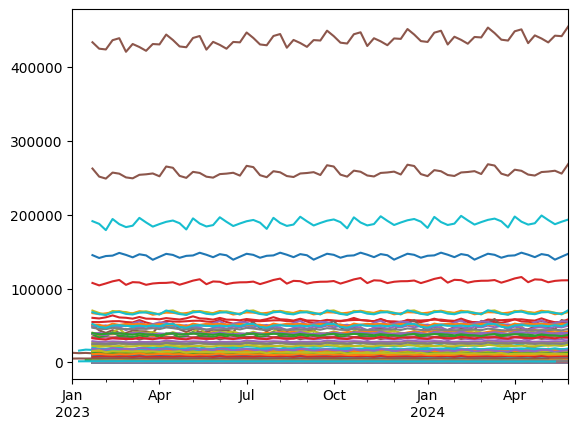

In [7]:
def Proyeccion(cd,columnName,df3,periodos,ptrend,pseasonal,pdamped,puse,tipo):
        df10 = df3[df3[columnName] > 0]
        df10 = df10[['Periodo', columnName]]
        df10 = df10.set_index('Periodo')
     
        #df10.plot(figsize=(12, 5))
        # Analisis de descomposicion
        #components = seasonal_decompose(df10, period=8)
        #components.plot()
        # Proyeccion
        fit1 = ExponentialSmoothing(df10, seasonal_periods=periodos,trend=ptrend,seasonal=pseasonal,damped_trend=pdamped,use_boxcox=puse,initialization_method="estimated",missing="drop").fit()
        #print(fit1.summary())
        # Calcula el intervalo de confianza al 95% y lo salva
        xhat = fit1.forecast(steps= pproyeccion)
        z = 1.96
        sse = fit1.sse
        predint_xminus = xhat - z * np.sqrt(sse/len(df10))
        predint_xplus  = xhat + z * np.sqrt(sse/len(df10))

        df = [predint_xminus,predint_xplus]
        df = pd.DataFrame(df)
        df = df.transpose()
        col0 = columnName + "_minimo"
        col1 = columnName + "_maximo"

        # Changing columns name with index number
        mapping = {df.columns[0]: col0, df.columns[1]: col1}
        df = df.rename(columns=mapping)

        # Salva los intervalos

        mdir = os.path.join(dir_actual, Pais)
        mfila = cd+"-"+tipo+"-"+vista + '-_intervalo_'+columnName+'.xlsx'
        dirPath = os.path.join(mdir, mfila)
        #df.to_excel(dirPath, index_label="Periodo")


        # Intervalo de confianza por simulacion
        simulations = fit1.simulate(pproyeccion, repetitions=1, error="add", random_errors=None)
        #ax = df10.plot(figsize=(12, 5),marker="o",color="black",title="Proyeccion",)
        #ax.set_ylabel("Venta")
        #ax.set_xlabel("Periodo")
        #fit1.fittedvalues.plot(ax=ax, style="--", color="green")
        #fit1.forecast(steps=pproyeccion).rename("Proyeccion").plot(ax=ax, style="--", marker="o", color="green", legend=True )


        # Grafica la serie de Ajuste y la añade a fit1
        df6 = fit1.forecast(pproyeccion)
        df6.plot()
        df7 = fit1.predict(0)

        df8 = [df7,df6]

        #df1 = (df0[[columnName]])

        df = pd.DataFrame(df8)
        df = df.transpose()
        col0 = columnName + "_ajuste"
        col1 = columnName + "_proyeccion"
        col2 = columnName 

        # Changing columns name with index number
        mapping = {df.columns[0]: col0, df.columns[1]: col1}
        df = df.rename(columns=mapping)
        df = df.fillna(0)
        df[col2] = df[col1].add(df10[columnName],fill_value=0)
        # Salva la proyeccion normal
        mdir = os.path.join(dir_actual, Pais)
        mfila = cd+"-"+tipo+"-"+ vista + '-py_'+columnName+'.xlsx'
        dirPath = os.path.join(mdir, mfila)
        df.to_excel(dirPath, index_label="Periodo")

        # Calcula el Error por medio del MAPE
        df99 = [df7]
        yy = pd.DataFrame(df99)
        yy = yy.transpose()
        xx = pd.DataFrame(df10)
        print("MAPE " +cd+"-"+ columnName + " = " + str(mape(xx,yy)))
        print("WMAPE " +cd+"-"+ columnName + " = " + str(wmape(xx,yy)))

def Procesamiento(df,cd,tipo):
    for (columnName, columnData) in df.items():
        #print('Column Name : ', columnName)
        #print('Column Contents : ', columnData.values)
        # Parametros personalizados
        ptrend = 'add'
        pseasonal = 'add'
        pdamped = True
        puse = True
        periodos = 12

        if (columnName != 'Periodo') :
           try:
                Proyeccion(cd,columnName,df,periodos,ptrend,pseasonal,pdamped,puse,tipo)
           except:
                Proyeccion(cd,columnName,df,4,ptrend,pseasonal,pdamped,puse,tipo)


for cd in cdlist:

    totalcds = e2s[cd]
    totalcds = totalcds.drop("Total")
    totalcdc = e2c[cd]
    totalcdc = totalcdc.drop("Total")



    dfps2 = dfproyeccioness[cd]
    dfps2 = dfps2.loc[:, dfps2.columns.isin(matstoprojects[cd])]
    dfps2['Total'] = totalcds
    dfps2['Periodo'] = pd.date_range(start="2/02/2020", periods=dfps2.shape[0], freq="W")
    dfps2.to_excel(cd +"test.xlsx", index_label="Periodo")
    Procesamiento(dfps2,cd,"Salchicha")

    dfpc2 = dfproyeccionesc[cd]
    dfpc2 = dfpc2.loc[:, dfpc2.columns.isin(matstoprojectc[cd])]
    dfpc2['Total'] = totalcdc
    dfpc2['Periodo'] = pd.date_range(start="2/02/2020", periods=dfpc2.shape[0], freq="W")
    dfpc2.to_excel(cd +"testc.xlsx", index_label="Periodo")
    Procesamiento(dfpc2,cd,"Chorizo")



In [8]:
# Une la salida

for cd in cdlist:
    for tipo in ["Salchicha","Chorizo"]:
        df=[]

        mdir = os.path.join(dir_actual, Pais)
        mfila = os.path.join(mdir, cd +"-"+tipo+"-"+ vista + "-py*")
        files = glob.glob(mfila)
        #print(mfila)
        for a in files:
            df.append( pd.read_excel(a, sheet_name='Sheet1'))

        i = 0
        for x in df:
            if i > 0 :
                dt = pd.merge(dt, df[i])
            else :
                dt = df[0]
            i = i + 1
       
        # Salva la proyeccion final de cada serie
        mdir = os.path.join(dir_actual, Pais)
        mfila = cd+"-"+tipo+"-"+ vista + '-Reporte_Final.xlsx'
        dirPath = os.path.join(mdir, mfila)
        dt= dt.set_index('Periodo')
        dt = dt[dt.columns.drop(list(dt.filter(regex='_ajuste')))]
        dt = dt[dt.columns.drop(list(dt.filter(regex='_proyeccion')))]
        dt2= dt.iloc[:, :-1].sum(axis=1)
        dt['A'] = dt2
        dt['B+C'] = dt['Total'] - dt['A']
        dt.insert(0, 'B+C', dt.pop('B+C'))
        dt.insert(0, 'A', dt.pop('A'))
        print(dt)
        dt.to_excel(dirPath)

      

                        A            B+C  M1000497_minimo  M1000497_maximo  \
Periodo                                                                      
2023-01-22  694864.897440 -549583.406469      1236.147624      2528.721284   
2023-01-29  683254.395998 -541839.633073      1017.027602      2309.601262   
2023-02-05  689749.808294 -545687.565593      1005.265723      2297.839383   
2023-02-12  695818.605093 -551197.884569      1280.736120      2573.309779   
2023-02-19  711849.906319 -563536.158788      1242.593320      2535.166980   
...                   ...            ...              ...              ...   
2024-05-05  718669.068040 -571987.390388      1847.976822      3140.550482   
2024-05-12  705581.570643 -560445.977200      1604.048580      2896.622240   
2024-05-19  678304.832400 -539128.647465      1561.588237      2854.161897   
2024-05-26  699524.719325 -556312.619272      1822.392722      3114.966382   
2024-06-02  716677.909469 -569498.930023      1394.991663      2

                        A           B+C  M1037101_minimo  M1037101_maximo  \
Periodo                                                                     
2023-01-22  120966.668002 -87533.026659     12937.150834     18222.210686   
2023-01-29  117898.640829 -86026.356978     12293.618038     17578.677890   
2023-02-05  116685.744281 -84620.014564     11960.041197     17245.101050   
2023-02-12  120580.617280 -87233.535609     12447.479008     17732.538860   
2023-02-19  124056.575056 -90300.903696     12601.692236     17886.752088   
...                   ...           ...              ...              ...   
2024-05-05  119362.534548 -87201.890051     12361.066668     17646.126521   
2024-05-12  115254.740860 -83788.196570     11454.303012     16739.362864   
2024-05-19  112829.478411 -81632.166411     11410.876003     16695.935856   
2024-05-26  114134.357373 -82902.083676     11695.036285     16980.096137   
2024-06-02  119982.542274 -87203.684587     12726.203318     18011.263170   

                        A            B+C  M1000820_minimo  M1000820_maximo  \
Periodo                                                                      
2023-01-22  235527.062075 -185888.633050       590.286813      1045.183048   
2023-01-29  232433.227448 -183592.446469       566.370152      1021.266387   
2023-02-05  241813.799295 -191848.140905       580.253462      1035.149697   
2023-02-12  232400.494694 -184375.632954       646.261204      1101.157439   
2023-02-19  243498.066909 -193412.185302       602.501074      1057.397309   
...                   ...            ...              ...              ...   
2024-05-05  275915.115812 -219008.362826       732.940155      1187.836390   
2024-05-12  260856.733717 -209177.366821       713.880583      1168.776818   
2024-05-19  262225.998013 -209230.389360       654.381830      1109.278064   
2024-05-26  273930.307938 -218336.927186       792.862937      1247.759172   
2024-06-02  267445.890130 -212366.874600       757.296702      1

                        A           B+C  M1037101_minimo  M1037101_maximo  \
Periodo                                                                     
2023-01-22  100453.628467 -67980.910636      3655.492630      7770.858010   
2023-01-29   96533.743783 -65171.359071      3658.938667      7774.304047   
2023-02-05  100955.779681 -68481.427013      3622.574896      7737.940276   
2023-02-12   99351.735809 -67469.948028      4065.482593      8180.847973   
2023-02-19   98499.962545 -66748.522787      3972.769065      8088.134445   
...                   ...           ...              ...              ...   
2024-05-05  111038.382598 -76535.487043      5238.461292      9353.826672   
2024-05-12  104996.444595 -71752.548761      4331.445172      8446.810552   
2024-05-19  104354.455866 -71048.387240      4086.289832      8201.655212   
2024-05-26  107602.008061 -73571.480250      4269.897100      8385.262480   
2024-06-02  104734.742845 -71242.407272      3905.787884      8021.153264   

                        A            B+C  M1000031_minimo  M1000031_maximo  \
Periodo                                                                      
2023-01-22  295024.717718 -224918.098313       251.938424       521.914502   
2023-01-29  284513.105610 -217715.830208       236.899582       506.875659   
2023-02-05  271991.335858 -207591.217947       233.614447       503.590525   
2023-02-12  294039.583524 -224493.891963       221.677461       491.653539   
2023-02-19  292228.124845 -223581.596383       248.549623       518.525700   
...                   ...            ...              ...              ...   
2024-05-05  294611.157749 -226147.997901       231.281720       501.257797   
2024-05-12  297839.163673 -228652.759998       265.547224       535.523302   
2024-05-19  290937.716594 -223734.879738       250.075901       520.051979   
2024-05-26  281146.104997 -216203.102901       227.275950       497.252027   
2024-06-02  299290.845071 -229938.305476       244.879396       

                        A            B+C  M1000195_minimo  M1000195_maximo  \
Periodo                                                                      
2023-01-22  248240.941185 -180367.501877      3605.460741      6269.125442   
2023-01-29  242052.366370 -176779.376145      3206.657049      5870.321750   
2023-02-05  236253.548729 -172145.274727      2952.060510      5615.725211   
2023-02-12  247703.571578 -180135.147241      3465.419576      6129.084277   
2023-02-19  249339.380469 -180995.858506      3375.422260      6039.086960   
...                   ...            ...              ...              ...   
2024-05-05  248084.216247 -180346.684413      3613.774668      6277.439368   
2024-05-12  246788.813060 -178746.103401      3282.348428      5946.013128   
2024-05-19  243533.308425 -176709.033092      3072.829738      5736.494439   
2024-05-26  239574.167341 -174177.272191      3167.851109      5831.515810   
2024-06-02  256951.883844 -186346.084283      3179.815874      5

                       A          B+C  M1037103_minimo  M1037103_maximo  \
Periodo                                                                   
2023-01-22  14323.157054 -7930.554230       308.560533       716.740404   
2023-01-29  13844.551619 -7657.505386       286.063116       694.242987   
2023-02-05  12926.745696 -7198.668829       286.107385       694.287256   
2023-02-12  13683.797753 -7653.811763       337.185322       745.365193   
2023-02-19  13656.136067 -7628.953873       329.833957       738.013829   
...                  ...          ...              ...              ...   
2024-05-05  13824.311519 -7582.620440       242.886518       651.066389   
2024-05-12  13310.495737 -7365.488798       269.404017       677.583889   
2024-05-19  13280.898826 -7384.296423       291.808071       699.987942   
2024-05-26  13299.844538 -7391.255301       290.132086       698.311957   
2024-06-02  13579.909603 -7515.481563       279.594572       687.774444   

            Total_minimo

                       A          B+C  Total_minimo  Total_maximo        Total
Periodo                                                                       
2023-01-01  10017.877267 -5008.938634   4066.446855   5951.430413  5008.938634
2023-01-08  10321.341451 -5160.670725   4218.178946   6103.162504  5160.670725
2023-01-15  10108.987950 -5054.493975   4112.002196   5996.985754  5054.493975
2023-01-22  10256.858141 -5128.429071   4185.937292   6070.920850  5128.429071
2023-01-29  10090.228283 -5045.114142   4102.622363   5987.605921  5045.114142
...                  ...          ...           ...           ...          ...
2024-04-14   9775.915896 -4887.957948   3945.466169   5830.449727  4887.957948
2024-04-21   9691.947093 -4845.973546   3903.481767   5788.465325  4845.973546
2024-04-28   9673.975497 -4836.987749   3894.495970   5779.479528  4836.987749
2024-05-05   9754.715621 -4877.357811   3934.866032   5819.849590  4877.357811
2024-05-12  10092.021383 -5046.010692   4103.518912 

                       A           B+C  M1000031_minimo  M1000031_maximo  \
Periodo                                                                    
2023-01-22  71311.464510 -56225.687914       173.783946       392.042885   
2023-01-29  75803.530964 -59618.965105       206.166657       424.425596   
2023-02-05  68022.203377 -54293.299011       197.517968       415.776907   
2023-02-12  72437.866682 -57588.524753       198.344451       416.603389   
2023-02-19  70786.167071 -56089.008562       162.379536       380.638475   
...                  ...           ...              ...              ...   
2024-05-05  64497.076549 -52588.375683       205.413208       423.672147   
2024-05-12  63076.746663 -51659.026551       200.926682       419.185621   
2024-05-19  63732.284657 -51907.903637       198.097355       416.356294   
2024-05-26  62818.441052 -51604.570918       211.449673       429.708612   
2024-06-02  63683.072876 -52167.225962       212.456856       430.715794   

           

MAPE Lineas-Chorizo y Variedades = 7.074264361342124
WMAPE Lineas-Chorizo y Variedades = 6.537458119692897
MAPE Lineas-Salchicha = 4.516067796476548
WMAPE Lineas-Salchicha = 4.510701995706302


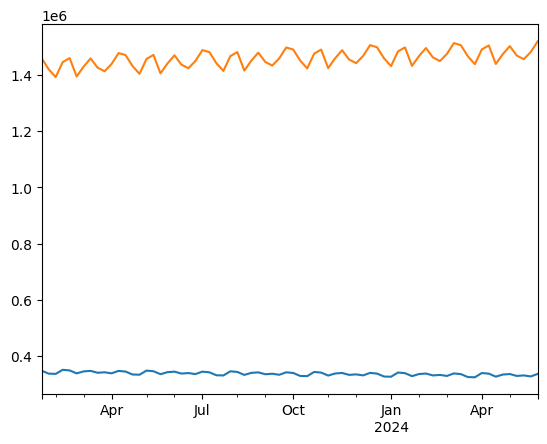

In [9]:
Procesamiento(e1,"Lineas","Proyeccion")
df=[]

mdir = os.path.join(dir_actual, Pais)
mfila = os.path.join(mdir, "Lineas-Proyeccion-CarnicosData-ini-py*")
files = glob.glob(mfila)
#print(mfila)
for a in files:
    df.append( pd.read_excel(a, sheet_name='Sheet1'))

i = 0
for x in df:
    if i > 0 :
        dt = pd.merge(dt, df[i])
    else :
        dt = df[0]
    i = i + 1
       
# Salva la proyeccion final de cada serie
mdir = os.path.join(dir_actual, Pais)
mfila = 'Lineas-Proyeccion-CarnicosData-Reporte_Final.xlsx'
dirPath = os.path.join(mdir, mfila)
dt= dt.set_index('Periodo')
dt = dt[dt.columns.drop(list(dt.filter(regex='_ajuste')))]
dt = dt[dt.columns.drop(list(dt.filter(regex='_proyeccion')))]
dt.to_excel(dirPath)